In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.linalg import eigh
from scipy.sparse import csr_matrix, save_npz, load_npz, kron, identity
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import expm
# matplotlib parameters 
large = 40; med = 25; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': small,
          'axes.labelsize': med ,
          'axes.titlesize': small ,
          'xtick.labelsize': small ,
          'ytick.labelsize': small ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]     
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern Roman']     
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

# Lindblad equation

In [10]:
# Pauli matrices and identity (sparse format)
I2 = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

J_total = 1

Delta = 0.5
gamma = 0.2

gamma_e = gamma
gamma_d = gamma

""" Hamiltonian for the infinite ranged Ising model. """
def build_hamiltonian(n):

    H = csr_matrix((2**n, 2**n), dtype=complex)

    # Infinite ranged XX term.
    for i in range(n-1):
        for j in range(i+1, n):
            X_ops = [I2] * n
            X_ops[i] = sigma_x
            X_ops[j] = sigma_x
            X_term = X_ops[0]
            for op in X_ops[1:]:
                X_term = kron(X_term, op)

            H += J_total * X_term

    for i in range(n-1):
        Z_ops = [I2] * n
        Z_ops[i] = sigma_z
        Z_term = Z_ops[0]
        for op in Z_ops[1:]:
            Z_term = kron(Z_term, op)  

        H -= Delta * Z_term      

    return H
    
def build_liouvillian(n):
    """Construct the Liouvillian superoperator."""
    H = build_hamiltonian(n)
    d = H.shape[0]
    I = identity(d, format="csr")
    
    # Hamiltonian contribution
    H_comm = -1j * (kron(H, I) - kron(I, H.conj().T))

    # Lindblad contributions
    lindblad_diss_term_1 = csr_matrix((H_comm.shape[0], H_comm.shape[0]), dtype=complex)
    lindblad_diss_term_2 = csr_matrix((H_comm.shape[0], H_comm.shape[0]), dtype=complex)

    # Lindblad contributions at each site.
    for i in range(n):

        sigma_minus_i = [I2] * n
        sigma_minus_i[i] = (sigma_x - 1j * sigma_y) / 2

        sigma_z_i = [I2] * n
        sigma_z_i[i] = (I2 + sigma_z)/2
        
        sigma_minus_i_op = sigma_minus_i[0]
        sigma_z_i_op = sigma_z_i[0]

        # Construct the jump operator matrices.
        for j in range(1, n):
            sigma_minus_i_op = kron(sigma_minus_i_op, sigma_minus_i[j])
            sigma_z_i_op = kron(sigma_z_i_op, sigma_z_i[j])

        L_1 = np.sqrt(gamma_e) * sigma_minus_i_op
        L_2 = np.sqrt(gamma_d) * sigma_z_i_op

        lindblad_diss_term_1 +=  kron(L_1, L_1.conj()) - 0.5 * (kron(I, L_1.getH() @ L_1) + kron((L_1.getH() @ L_1).T, I))
        lindblad_diss_term_2 += kron(L_2, L_2.conj()) - 0.5 * (kron(I, L_2.getH() @ L_2) + kron((L_2.getH() @ L_2).T, I))

    return H_comm + lindblad_diss_term_1 + lindblad_diss_term_2

def cost_function(rho, L_vec):
    """Compute the cost function Tr[(L(rho))^2]."""
    rho_vec = rho.flatten(order="F")  # Vectorize rho
    L_rho_vec = L_vec @ rho_vec  # Apply Liouvillian
    cost = np.linalg.norm(L_rho_vec)**2  # Compute squared norm
    return cost

def lindblad_time_evolution_with_cost(n, rho_0, t_max, dt):
    """Simulate Lindblad equation and compute cost function at each step."""
    d = 2**n
    L_vec = build_liouvillian(n)
    rho_vec = rho_0.flatten(order="F")  # Vectorize initial state

    times = np.arange(0, t_max, dt)
    results = []
    costs = []

    for t in times:
        # Compute cost function
        rho = rho_vec.reshape((d, d), order="F")  # Reshape back to density matrix
        cost = cost_function(rho, L_vec)
        costs.append(cost)

        # Time evolution using matrix exponential
        exp_Lt = expm(L_vec * dt)
        rho_vec = exp_Lt @ rho_vec  # Update density matrix

        results.append(rho)

    return times, results, costs

In [11]:
# Simulation parameters
n = 5  # Number of qubits
t_max = 5
dt = 0.1


# Helper function to construct the tensor product of single-qubit states
def build_initial_state(n):
    """Construct the initial state |0><0| for n qubits."""
    # Single-qubit |0><0| state
    rho_single = csr_matrix([[1, 0], [0, 0]], dtype=complex)

    # Tensor product to extend to n qubits
    rho_0 = rho_single
    for _ in range(n - 1):
        rho_0 = kron(rho_0, rho_single)

    return rho_0.toarray()  # Convert to dense array if needed

rho_0 = build_initial_state(n) # Initial state
# Run simulation with cost function
times, results, costs = lindblad_time_evolution_with_cost(n, rho_0, t_max, dt)

#populations = [np.real(rho[0, 0]) for rho in results]

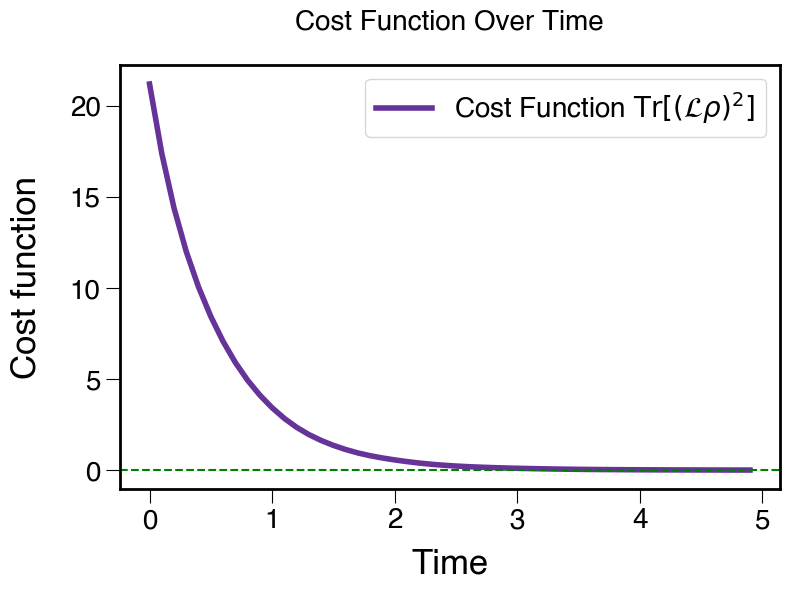

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(times, costs, label=r"Cost Function $\text{Tr}[(\mathcal{L}\rho)^2]$", color="rebeccapurple", lw=4)
plt.legend()
plt.xlabel("Time", labelpad=10)
plt.ylabel("Cost function", labelpad=20)
#plt.yscale("log")  # Optional: Log scale for better visualization
plt.title("Cost Function Over Time")
plt.axhline(0, color="green", linestyle="--")
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.savefig("XXZ_n_"+str(n)+ "_Delta_"+ str(Delta)+ "_g_1_"+ str(gamma_1)+ "_g_2_"+ str(gamma_2)+".png", dpi=600, bbox_inches="tight")
plt.show()